In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from easy_datastore import download_item

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [4]:
from easy_datastore.functions import login
from pathlib import Path

dc = login()
file_manager = dc.file_manager
item = "a1a0d3a7-6723-47f0-86cc-5f42e69435b5"
download_fpath = Path(item)
with open(download_fpath, "wb") as fo:
    res = file_manager._download_file(fo, item, stream=False)


Successfully loaded refresh_token=[0.AR...dNSo] from secrets.
/home/maer3/anaconda/envs/patch-gnn/lib/python3.8/site-packages/dc/managers/fs/fs_manager.py:108: RuntimeWarning: Local mounter was disabled due to an exception 'ERROR: Client SDK, 500, cannot mount anything without goofys executable'
  warnings.warn(f"Local mounter was disabled due to an exception '{str(ex)}'", RuntimeWarning)
/home/maer3/anaconda/envs/patch-gnn/lib/python3.8/site-packages/dc/managers/fs/fs_manager.py:115: RuntimeWarning: Cluster mounter was disabled due to an exception 'ERROR: Client SDK, 500, please install pyspark before use '__init__''
  warnings.warn(f"Cluster mounter was disabled due to an exception '{str(ex)}'", RuntimeWarning)


/home/maer3/github/research/sda-patch-gnn/notebooks/maer3/a1a0d3a7-6723-47f0-86cc-5f42e69435b5  26251981 / 0.0  (0.00%)

In [5]:
res.file_name

'a1a0d3a7-6723-47f0-86cc-5f42e69435b5'

In [6]:
import zipfile

In [7]:
z = zipfile.ZipFile(file=item)
z.extractall()

## Custom parser to read SASA calculations

In [8]:
fname = "pops_out/A6NEC2_pops.out"
with open(fname, "r+") as f:
    sasa = f.readlines()

In [ ]:
from collections import defaultdict

sasa_raw = defaultdict(list)
sasa_type = ""
for line in sasa:
    if "===" in line:
        sasa_type = line.split("===")[1].strip(" ")
    sasa_raw[sasa_type].append(line)


data = "".join(l.replace("\t\t", "\t") for l in sasa_raw["RESIDUE SASAs"][1:])
pd.read_csv(StringIO(data), sep="\t")

In [81]:
from patch_gnn.solvent import pops2df

In [85]:
import os
from pathlib import Path
from tqdm.auto import tqdm
from typing import List

pops_dir = Path("pops_out")
pops_files = [f for f in os.listdir(pops_dir) if f.endswith(".out")]
accessions = [f.split("_")[0] for f in pops_files]

sasa_dfs = dict()
for file, accession in tqdm(zip(pops_files, accessions)):
    sasa_dfs[accession] = pops2df(pops_dir / file, wanted_sasa="RESIDUE SASAs")

Taken from: https://github.com/Fraternalilab/POPSlegacy

RESIDUE SASAs

- ResidNe : residue name in molecular coordinate file
- Chain : chain name in molecular coordinate file (can be void)
- ResidNr : residue number in molecular coordinate file
- Phob/A^2 : hydrophobic solvent accessible surace area in Angstrom^2 units
- Phil/A^2 : hydrophilic solvent accessible surace area in Angstrom^2 units
- Total/A^2 : total solvent accessible surace area in Angstrom^2 units
- Q(SASA) : quotient of SASA and Surf (below), i.e. the fraction of SASA
- N(overl) : number of overlaps with residue neighbours - calculated from solvent. Should be inversely proportional to exposure.
- Surf/A^2 : surface area of isolated residue



In [16]:
from pyprojroot import here
import pickle as pkl

with open(here() / "data/ghesquire_2011/sasa.pkl", "wb") as f:
    pkl.dump(sasa_dfs, f)

In [17]:
Path(item).unlink()

## Simple linear model using SASA scores to predict oxidation

In [18]:
import janitor

In [19]:
from patch_gnn.data import load_ghesquire
from patch_gnn.graph import met_position
import pickle as pkl

graph_pickle_path = here() / "data/ghesquire_2011/graphs.pkl"

with open(graph_pickle_path, "rb") as f:
    graphs = pkl.load(f)

data = load_ghesquire()
filtered = (
    data
    .query("`accession-sequence` in @graphs.keys()")
    .query("ox_fwd_logit < 0.0")
    .join_apply(met_position, "met_position")
)

/tmp/8b87b9c3-00b6-4bec-b305-acd390f01afe  417511 / 0.0  (0.00%)

In [20]:
sasa_dfs["A6NEC2"].query("ResidNr == 216").columns

Index(['ResidNe', 'Chain', 'ResidNr', 'iCode', 'Phob/A^2', 'Phil/A^2',
       'SASA/A^2', 'Q(SASA)', 'N(overl)', 'Surf/A^2'],
      dtype='object')

In [21]:
sasa_feat_columns = ['ResidNe', 'Phob/A^2', 'Phil/A^2', 'SASA/A^2', 'Q(SASA)', 'N(overl)', 'Surf/A^2']

In [22]:
filtered

,accession,Description,sequence,isoforms,end,score,threshold,m/z,z,ppm,%ox_fwd,val_fwd,%ox_rev,val_rev,ox_fwd_logit,ox_rev_logit,accession-sequence,met_position
9,A6NEC2,Puromycin-sensitive aminopeptidase-like protein,VALSNMNVIDR,P55786 (211-221),221.0,69.0,25.0,632.3219,2.0,0.237600,1.057476,NaN,2.150,NaN,-4.538654,-3.817968,A6NEC2-VALSNMNVIDR,216.0
12,A6NIZ1,Ras-related protein Rap-1b-like protein,DTDDVPMILVGNK,P61224 (15-117),117.0,58.0,32.0,724.8511,2.0,0.759833,3.633391,NaN,NaN,NaN,-3.277993,NaN,A6NIZ1-DTDDVPMILVGNK,111.0
18,A8MWD9,Small nuclear ribonucleoprotein G-like protein,GNSIIMLEALERV,P6238 (64-76),76.0,43.0,34.0,738.8908,2.0,1.151945,4.104501,V,NaN,NaN,-3.151175,NaN,A8MWD9-GNSIIMLEALERV,69.0
26,O00170,AH receptor-interacting protein,GKPMELIIGK,NaN,66.0,35.0,34.0,373.2144,3.0,0.000000,5.831856,NaN,NaN,NaN,-2.781747,NaN,O00170-GKPMELIIGK,60.0
27,O00186,Syntaxin-binding protein 3,IENESDMIR,NaN,440.0,49.0,34.0,569.7560,2.0,0.263737,2.168332,NaN,NaN,NaN,-3.809290,NaN,O00186-IENESDMIR,438.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2550,Q9Y3C4,TP53RK-binding protein,NLPEIMNITEVK,NaN,146.0,34.0,32.0,716.8719,2.0,0.907994,5.242244,NaN,NaN,NaN,-2.894574,NaN,Q9Y3C4-NLPEIMNITEVK,140.0
2555,Q9Y3E7,Charged multivesicular body protein 3,IPEIQATMR,NaN,128.0,58.0,24.0,545.7820,2.0,0.642468,0.271624,NaN,1.183,NaN,-4.595120,-4.425216,Q9Y3E7-IPEIQATMR,127.0
2560,Q9Y3L5,Ras-related protein Rap-2c,VDLEPEREVMSSEGR,NaN,132.0,65.0,31.0,588.9403,3.0,0.283479,28.043333,NaN,12.237,NaN,-0.942313,-1.970176,Q9Y3L5-VDLEPEREVMSSEGR,127.0
2609,Q9Y5W9,Sorting nexin-11,STMTVSDAILR,NaN,153.0,65.0,33.0,613.3087,2.0,0.653273,14.018914,NaN,NaN,NaN,-1.813720,NaN,Q9Y5W9-STMTVSDAILR,145.0


### Prototype annotation of graphs

In [87]:
import pickle as pkl

with open(here() / "data/ghesquire_2011/graphs.pkl", "rb") as f:
    graphs = pkl.load(f)

In [102]:
for acc_seq, g in tqdm(graphs.items()):
    accession = acc_seq.split("-")[0]
    sasa_df = sasa_dfs[accession]
    for n, d in g.nodes(data=True):
        res = d["residue_name"]
        num = d["residue_number"]
        sasa_info = sasa_df.query("ResidNe == @res").query("ResidNr == @num").iloc[0]
        g.nodes[n]["Phob/A^2"] = sasa_info["Phob/A^2"]
        g.nodes[n]["Phil/A^2"] = sasa_info["Phil/A^2"]
        g.nodes[n]["SASA/A^2"] = sasa_info["SASA/A^2"]
        g.nodes[n]["N(overl)"] = sasa_info["N(overl)"]

In [104]:
g.nodes(data=True)

NodeDataView({'82VAL': {'chain_id': '', 'residue_number': 82, 'residue_name': 'VAL', 'x_coord': 12.869, 'y_coord': 25.605, 'z_coord': 64.49, 'features': None, 'Phob/A^2': 13.37, 'Phil/A^2': 2.2, 'SASA/A^2': 15.57, 'N(overl)': 562}, '125MET': {'chain_id': '', 'residue_number': 125, 'residue_name': 'MET', 'x_coord': 9.81, 'y_coord': 26.269, 'z_coord': 55.166, 'features': None, 'Phob/A^2': 17.08, 'Phil/A^2': 4.19, 'SASA/A^2': 21.28, 'N(overl)': 626}, '128PHE': {'chain_id': '', 'residue_number': 128, 'residue_name': 'PHE', 'x_coord': 12.108, 'y_coord': 22.405, 'z_coord': 53.312, 'features': None, 'Phob/A^2': 20.84, 'Phil/A^2': 2.1, 'SASA/A^2': 22.94, 'N(overl)': 824}, '116MET': {'chain_id': '', 'residue_number': 116, 'residue_name': 'MET', 'x_coord': 5.162, 'y_coord': 27.414, 'z_coord': 57.489, 'features': None, 'Phob/A^2': 34.78, 'Phil/A^2': 7.18, 'SASA/A^2': 41.96, 'N(overl)': 632}, '126GLN': {'chain_id': '', 'residue_number': 126, 'residue_name': 'GLN', 'x_coord': 7.412, 'y_coord': 25.5

In [100]:
res = d["residue_name"]
num = d["residue_number"]
sasa_df.query("ResidNe == @res").query("ResidNr == @num").iloc[0]

ResidNe        THR
Chain            -
ResidNr        124
iCode            -
Phob/A^2     73.08
Phil/A^2     19.04
SASA/A^2     92.13
Q(SASA)     0.6037
N(overl)       385
Surf/A^2     152.6
Name: 114, dtype: object

In [88]:
graphs

{'Q9H0U4-MGPGAASGGERPNLK': <networkx.classes.graph.Graph at 0x7f272b487eb0>,
 'P15374-FLEESVSMSPEER': <networkx.classes.graph.Graph at 0x7f272b17ba60>,
 'Q9NPD3-SCEMGLQLR': <networkx.classes.graph.Graph at 0x7f2725d2f8b0>,
 'P52564-ADDLEPIMELGR': <networkx.classes.graph.Graph at 0x7f2727304490>,
 'P36542-EVMLVGIGDK': <networkx.classes.graph.Graph at 0x7f2727445730>,
 'P35244-MFILSDGEGK': <networkx.classes.graph.Graph at 0x7f2726faeca0>,
 'Q9ULP9-EIQLLQMANEK': <networkx.classes.graph.Graph at 0x7f27266b3e50>,
 'P46778-TNGKEPELLEPIPYEFMA': <networkx.classes.graph.Graph at 0x7f2726ca2d60>,
 'Q9H1K1-NVGTGLVGAPACGDVMK': <networkx.classes.graph.Graph at 0x7f27270f17f0>,
 'P10644-ILMGSTLR': <networkx.classes.graph.Graph at 0x7f2726ce44f0>,
 'Q96E11-ESGMNLNPEVEGTLIR': <networkx.classes.graph.Graph at 0x7f27268149a0>,
 'P30044-FSMVVQDGIVK': <networkx.classes.graph.Graph at 0x7f2726812f70>,
 'P62191-AICTEAGLMALR': <networkx.classes.graph.Graph at 0x7f2726c22520>,
 'Q13283-VMEKPSPLLVGR': <network

In [41]:
sasa_mets = []
for row, data in filtered.iterrows():
    accession = data["accession"]
    met_position = data["met_position"]
    sasa_feats = sasa_dfs[accession].query("ResidNr == @met_position")[sasa_feat_columns]
    sasa_feats["accession"] = accession
    sasa_feats["met_position"] = met_position
    sasa_feats["ox_fwd_logit"] = data["ox_fwd_logit"]
    sasa_feats["%ox_fwd"] = data["%ox_fwd"]
    sasa_mets.append(sasa_feats)

### Problematic SASA/PDB files

In [58]:
# We are dropping any of those that have incorrect MET position.
# TODO: Fix Excel table
import numpy as np

area_columns = [c for c in sasa_feat_columns if "A^2" in c]

sasa_df = pd.concat(sasa_mets).query("ResidNe == 'MET'").transform_columns(area_columns, np.log)
sasa_df

,ResidNe,Phob/A^2,Phil/A^2,SASA/A^2,Q(SASA),N(overl),Surf/A^2,accession,met_position,ox_fwd_logit,%ox_fwd
175,MET,2.820188,1.644805,3.089223,0.096,748,5.432411,A6NEC2,216.0,-4.538654,1.057476
110,MET,3.398193,1.593309,3.550479,0.1523,576,5.432411,A6NIZ1,111.0,-3.277993,3.633391
55,MET,4.640441,2.093098,4.715817,0.4884,368,5.432411,A8MWD9,69.0,-3.151175,4.104501
58,MET,3.230804,1.660131,3.419692,0.1336,510,5.432411,O00170,60.0,-2.781747,5.831856
431,MET,2.525729,1.731656,2.898671,0.0793,707,5.432411,O00186,438.0,-3.809290,2.168332
...,...,...,...,...,...,...,...,...,...,...,...
139,MET,3.652215,2.578701,3.946231,0.2262,472,5.432411,Q9Y3C4,140.0,-2.894574,5.242244
115,MET,2.628285,1.095273,2.823757,0.0736,617,5.432411,Q9Y3E7,127.0,-4.595120,0.271624
126,MET,4.600560,1.769855,4.657858,0.4609,462,5.432411,Q9Y3L5,127.0,-0.942313,28.043333
134,MET,3.816173,2.109000,3.982854,0.2347,486,5.432411,Q9Y5W9,145.0,-1.813720,14.018914


In [72]:
bad_mets = pd.concat(sasa_mets).query("ResidNe != 'MET'")

Uncovered a data quality issue here, "end" recorded in table may not necessarily be the correct end position for the sequence.

We will skip these guys for the time being.

In [67]:
y_column = "ox_fwd_logit"


In [73]:
from sklearn.linear_model import LinearRegression

In [74]:
X_columns = ["SASA/A^2", "N(overl)"]
y_column = "ox_fwd_logit"
lr = LinearRegression()
lr.fit(sasa_df[X_columns], sasa_df[y_column])

LinearRegression()

In [80]:
from sklearn.metrics import explained_variance_score as evs, mean_squared_error as mse
preds = lr.predict(sasa_df[X_columns])
evs(sasa_df[y_column], preds), mse(sasa_df[y_column], preds)

(0.22000221586051338, 1.0642195490436896)

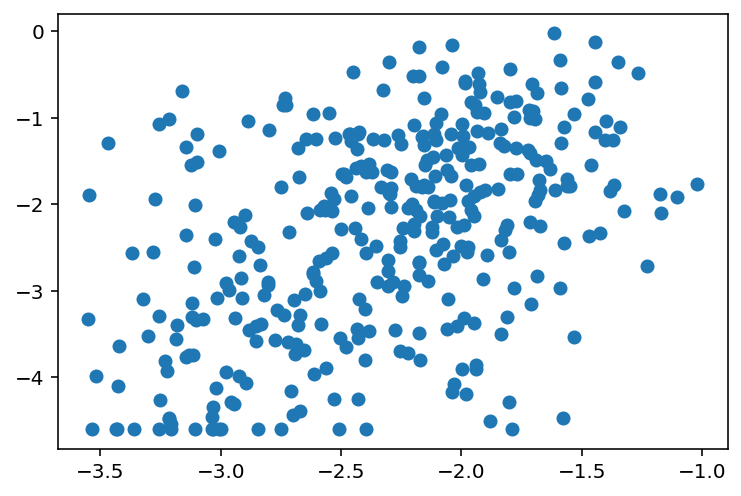

In [79]:
import matplotlib.pyplot as plt

plt.scatter(preds, sasa_df[y_column])

<AxesSubplot:xlabel='SASA/A^2', ylabel='ox_fwd_logit'>

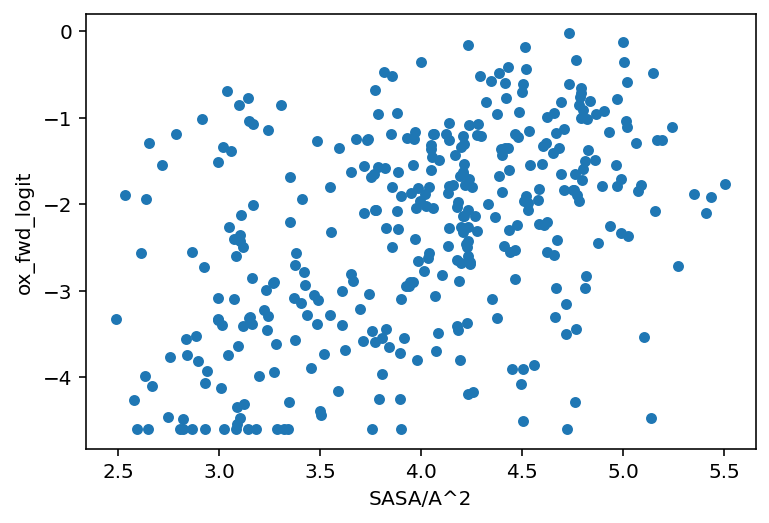

In [68]:
sasa_df.plot(kind="scatter", x="SASA/A^2", y=y_column)

<AxesSubplot:xlabel='Phil/A^2', ylabel='ox_fwd_logit'>

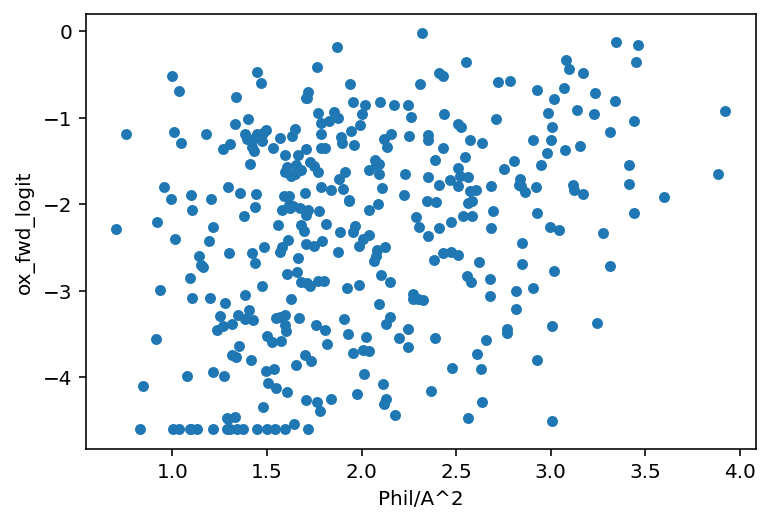

In [69]:
sasa_df.plot(kind="scatter", x="Phil/A^2", y=y_column)

<AxesSubplot:xlabel='Phob/A^2', ylabel='ox_fwd_logit'>

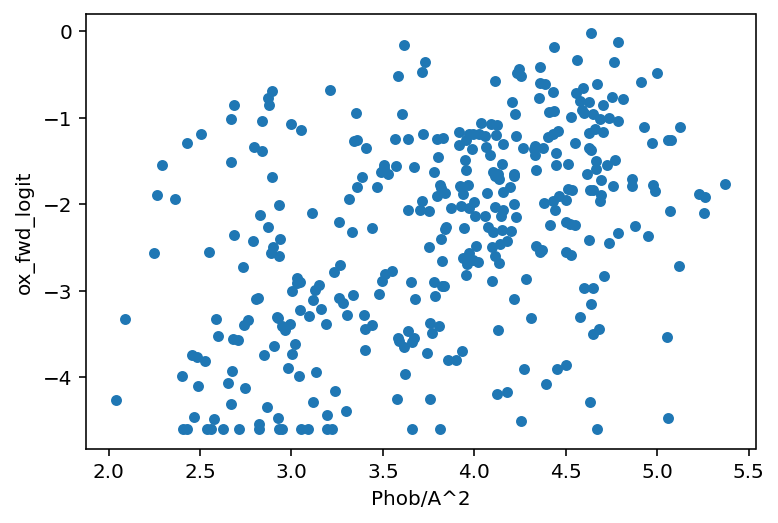

In [70]:
sasa_df.plot(kind="scatter", x="Phob/A^2", y=y_column)

<AxesSubplot:xlabel='N(overl)', ylabel='ox_fwd_logit'>

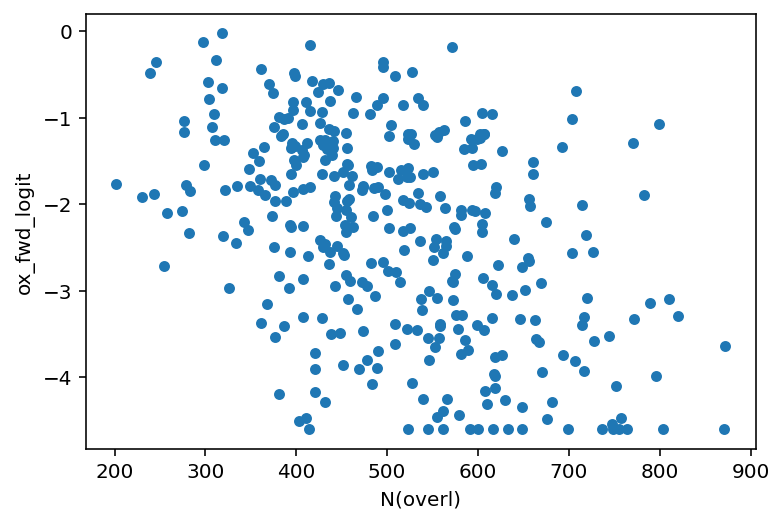

In [71]:
sasa_df.plot(kind="scatter", x="N(overl)", y=y_column)

In [ ]:
liauhyrfalo;wieyghlfkjhdalweuirgh